<a href="https://colab.research.google.com/github/jeffbgreene/geology-558/blob/main/Unsupervised_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unsupervised Learning
#### Unsupervised Learning focused on dimensionality reduction using asteroid data
#### Jeff Greene
#### 1/17/2025


In [1]:
# Install the requests library so that the API call to Asterank can be made
!pip install requests
!pip install umap-learn

In [2]:
import pandas as pd
import numpy as np

# For PCA
from sklearn.preprocessing import StandardScaler  # to standardize the features
from sklearn.decomposition import PCA  # to apply PCA

# For UMAP
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import QuantileTransformer
import umap

# For t-SNE
from sklearn.manifold import TSNE

# Metric used for scoring the differnt algorithms
from sklearn.manifold import trustworthiness

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Libraries for API call and JSON parsing
import requests
from pandas import json_normalize

# Set the figure size
plt.rcParams["figure.figsize"] = (25,25)
# Set the default font size
plt.rcParams.update({'font.size': 15})



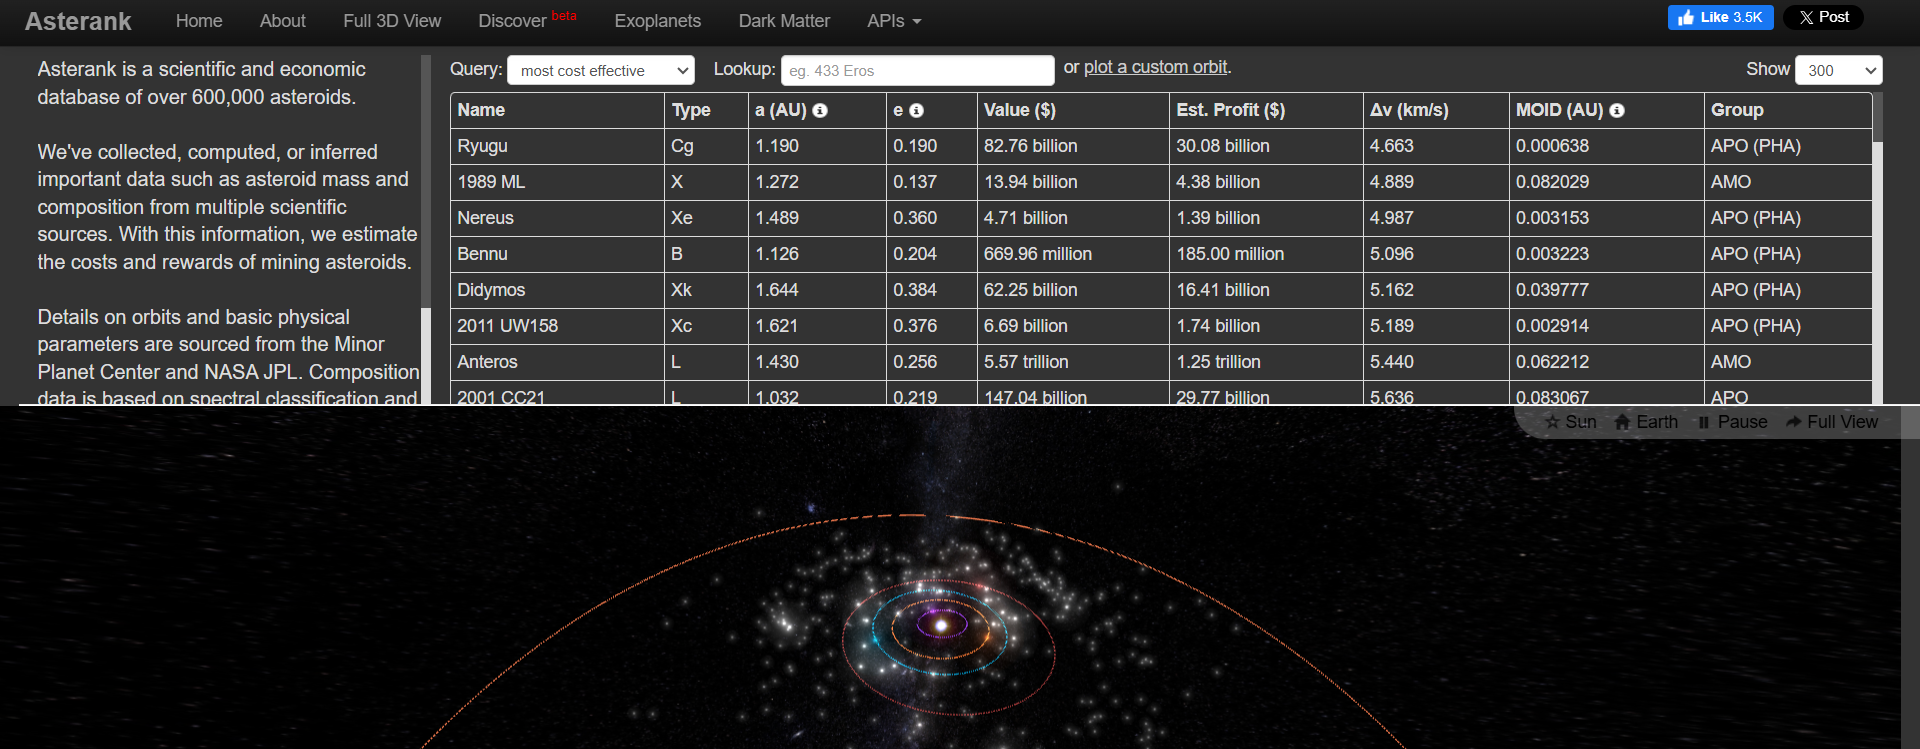

  *Figure 1: Screen capture of the Asterank website*


### Retrieving asteroid data sorted by valuation from the Asterank API

Below is a table of some of the column names that are in the data set and the description of what they are.

*Tabel 1: Attributes of the Asterank dataset*


| Attributes | Description |
| ---- | ---- |
| SPK-ID | Object primary SPK-ID |
| ID | Object internal database ID |
| Fullname | Object full name/designation |
| pdes | Object primary designation |
| NEO | Near-Earth Object (NEO) flag |
| PHA | Potentially Hazardous Asteroid (PHA) flag |
| H | Absolute magnitude parameter |
| Diameter | object diameter (from equivalent sphere) km Unit |
| Albedo | Geometric albedo |
| Diameter sigma | 1-sigma uncertainty in object diameter km Unit |
| Orbit id | Orbit solution ID |
| Epoch | Epoch of osculation in modified Julian day form |
| Equinox | Equinox of reference frame |
| e | Eccentricity |
| a | Semi-major axis au Unit |
| q | perihelion distance au Unit |
| i | inclination; angle with respect to x-y ecliptic plane |
| tp | Time of perihelion passage TDB Unit |
| moid ld | Earth Minimum Orbit Intersection Distance au Unit |

## Data set retrival and cleaning

---

I retrieved 5000 rows sorted by the asteroid valuation. According to Asterank, "Value estimates are based on the mass of a given asteroid and its spectral type. Asteroid spectra is used to infer composition, which, in conjunction with current market prices, determine potential value." [1]

This valuations are approximations and should not be considered as truthful values, as most likely these are "in-place" values, not accounting for the cost to travel to the asteroid, extract the material, return it to a processing location, and then treat, store and transport the materials for sale.

Although this unit is focused on unsupervised learning, I did extract a couple of features that could be utilized as labels and help determine the performance of the dimensionality reduction algorithms. These columns are potentially hazardous asteroids (PHA) and classification, which refers to the asteroids location in our solar system.

As far as data cleaning, I only kept columns with more than 4000 non-NAN values, dropped the SPK-ID and seperated out the PHA and Class columns. I then numerically encoded the PHA column to be a 1 for yes and 0 for no and used the Scikit Learn label encoder to numerically encode the Class column values. These updated coulmns replaced their counterparts in the dataframe. Finally, I dropped any columns that were listed as an object type (strings that can't be used in any of the unsupervised algorithms), and dropped rows with NAN values. This left me with 4,612 samples to use dimenstionality reduction.

For more in-depth knowledge of the EDA behind the dataset, please see the Unsupervised EDA notebook in this repo: https://github.com/jeffbgreene/geology-558/blob/main/Unsupervised_EDA.ipynb

In [3]:
# Using an API call to Asterank to get the first 5000 rows of data sorted by asteroid value
url = 'https://www.asterank.com/api/rankings?sort_by=value&limit=5000'
data = requests.get(url)

# Store the API response in a variable.
available_data = data.json()
df = json_normalize(available_data)
print(f'The length of the Asterank dataset for the unsupervised module is: {len(df)}')

The length of the Asterank dataset for the unsupervised module is: 5000


In [4]:
# Only keep colunns with 4000 or more non-NAN values
df.dropna(thresh=4000, axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 56 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sigma_tp        4874 non-null   float64
 1   epoch_mjd       5000 non-null   float64
 2   ad              5000 non-null   float64
 3   producer        5000 non-null   object 
 4   rms             5000 non-null   float64
 5   closeness       5000 non-null   float64
 6   prov_des        4743 non-null   object 
 7   tp              5000 non-null   float64
 8   full_name       5000 non-null   object 
 9   sigma_per       4874 non-null   float64
 10  equinox         5000 non-null   object 
 11  sigma_ad        4874 non-null   float64
 12  saved           5000 non-null   float64
 13  moid_ld         4997 non-null   float64
 14  neo             5000 non-null   object 
 15  profit          5000 non-null   float64
 16  spkid           5000 non-null   float64
 17  sigma_w         4874 non-null   f

In [5]:
df.head()

,sigma_tp,epoch_mjd,ad,producer,rms,closeness,prov_des,tp,full_name,sigma_per,...,om,e,i,spec,q,moid_jup,w,sigma_ma,dv,sigma_q
0,0.000050,58600.0,3.760305,Otto Matic,0.49535,2634.479570,1903 LU,2.458749e+06,511 Davida (1903 LU),0.000008,...,107.596326,0.188135,15.938225,C,2.569456,1.47719,337.440540,0.000009,11.144603,9.266100e-08
1,0.000720,58600.0,3.981728,Otto Matic,0.48923,2622.635949,1892 L,2.459550e+06,334 Chicago (1892 L),0.000029,...,130.163228,0.023502,4.643112,C,3.798870,1.07555,148.771059,0.000092,11.703702,1.808900e-07
2,0.000576,58600.0,3.247375,Otto Matic,0.44762,2631.736774,1910 KQ,2.458288e+06,702 Alauda (1910 KQ),0.000014,...,289.745523,0.017244,20.602228,B,3.137278,1.94887,350.767999,0.000100,12.757615,1.153300e-07
3,0.000289,58600.0,3.176470,Otto Matic,0.44609,2634.754684,1896 DB,2.458261e+06,423 Diotima (1896 DB),0.000008,...,69.374213,0.035882,11.244266,C,2.956412,1.85955,198.548794,0.000053,11.224330,1.117100e-07
4,0.000053,58600.0,3.966001,Otto Matic,0.49557,2635.271820,1893 AH,2.458078e+06,372 Palma (1893 AH),0.000009,...,327.356998,0.258992,23.825957,B,2.334280,1.57726,115.574876,0.000009,11.987880,1.189500e-07


In [6]:
df['class'].unique()
classes = ['MBA', 'OMB', 'CEN', 'TJN', 'MCA', 'APO', 'AMO', 'IMB', 'ATE',
       'TNO', 'IEO']

In [7]:
# Convert PHA label to numeric values
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

strings = df[['class']]
le.fit(strings)
integers = le.transform(strings)
df['class'] = integers

print(integers)
df['pha'] = df['pha'].replace({'Y': 1, 'N': 0})

[6 8 6 ... 6 6 6]


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:93: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
<ipython-input-7-72bd8203ba2f>:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['pha'] = df['pha'].replace({'Y': 1, 'N': 0})


In [8]:
# Keep only the columns that are numerical values (float64)
df_numeric = df.select_dtypes(exclude='object')
df_numeric.drop('spkid', axis=1, inplace=True)
df_numeric.shape

(5000, 43)

In [9]:
# Drop all the rows with NAN values for any column
df_numeric.dropna(inplace=True)

# Pull out the Labels (PHA) for use in UMAP
y_asteroid_class = df_numeric[["class"]].values.flatten()
y_pha = df_numeric[["pha"]].values.flatten()

df_numeric.drop(["pha", "class"], axis=1, inplace=True)

df_numeric.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4612 entries, 0 to 4999
Data columns (total 41 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   sigma_tp    4612 non-null   float64
 1   epoch_mjd   4612 non-null   float64
 2   ad          4612 non-null   float64
 3   rms         4612 non-null   float64
 4   closeness   4612 non-null   float64
 5   tp          4612 non-null   float64
 6   sigma_per   4612 non-null   float64
 7   sigma_ad    4612 non-null   float64
 8   saved       4612 non-null   float64
 9   moid_ld     4612 non-null   float64
 10  profit      4612 non-null   float64
 11  sigma_w     4612 non-null   float64
 12  epoch       4612 non-null   float64
 13  per         4612 non-null   float64
 14  data_arc    4612 non-null   float64
 15  sigma_i     4612 non-null   float64
 16  score       4612 non-null   float64
 17  per_y       4612 non-null   float64
 18  sigma_n     4612 non-null   float64
 19  epoch_cal   4612 non-null   floa

# PCA Dimensionality Reduction

## Standardize the data

---


#### As it is a good practice, I standardized the data just using the Scikit Learn StandardScaler class on the feature set

In [10]:
#Standardize the features
scalar = StandardScaler()
scaled_data = pd.DataFrame(scalar.fit_transform(df_numeric)) #scaling the data

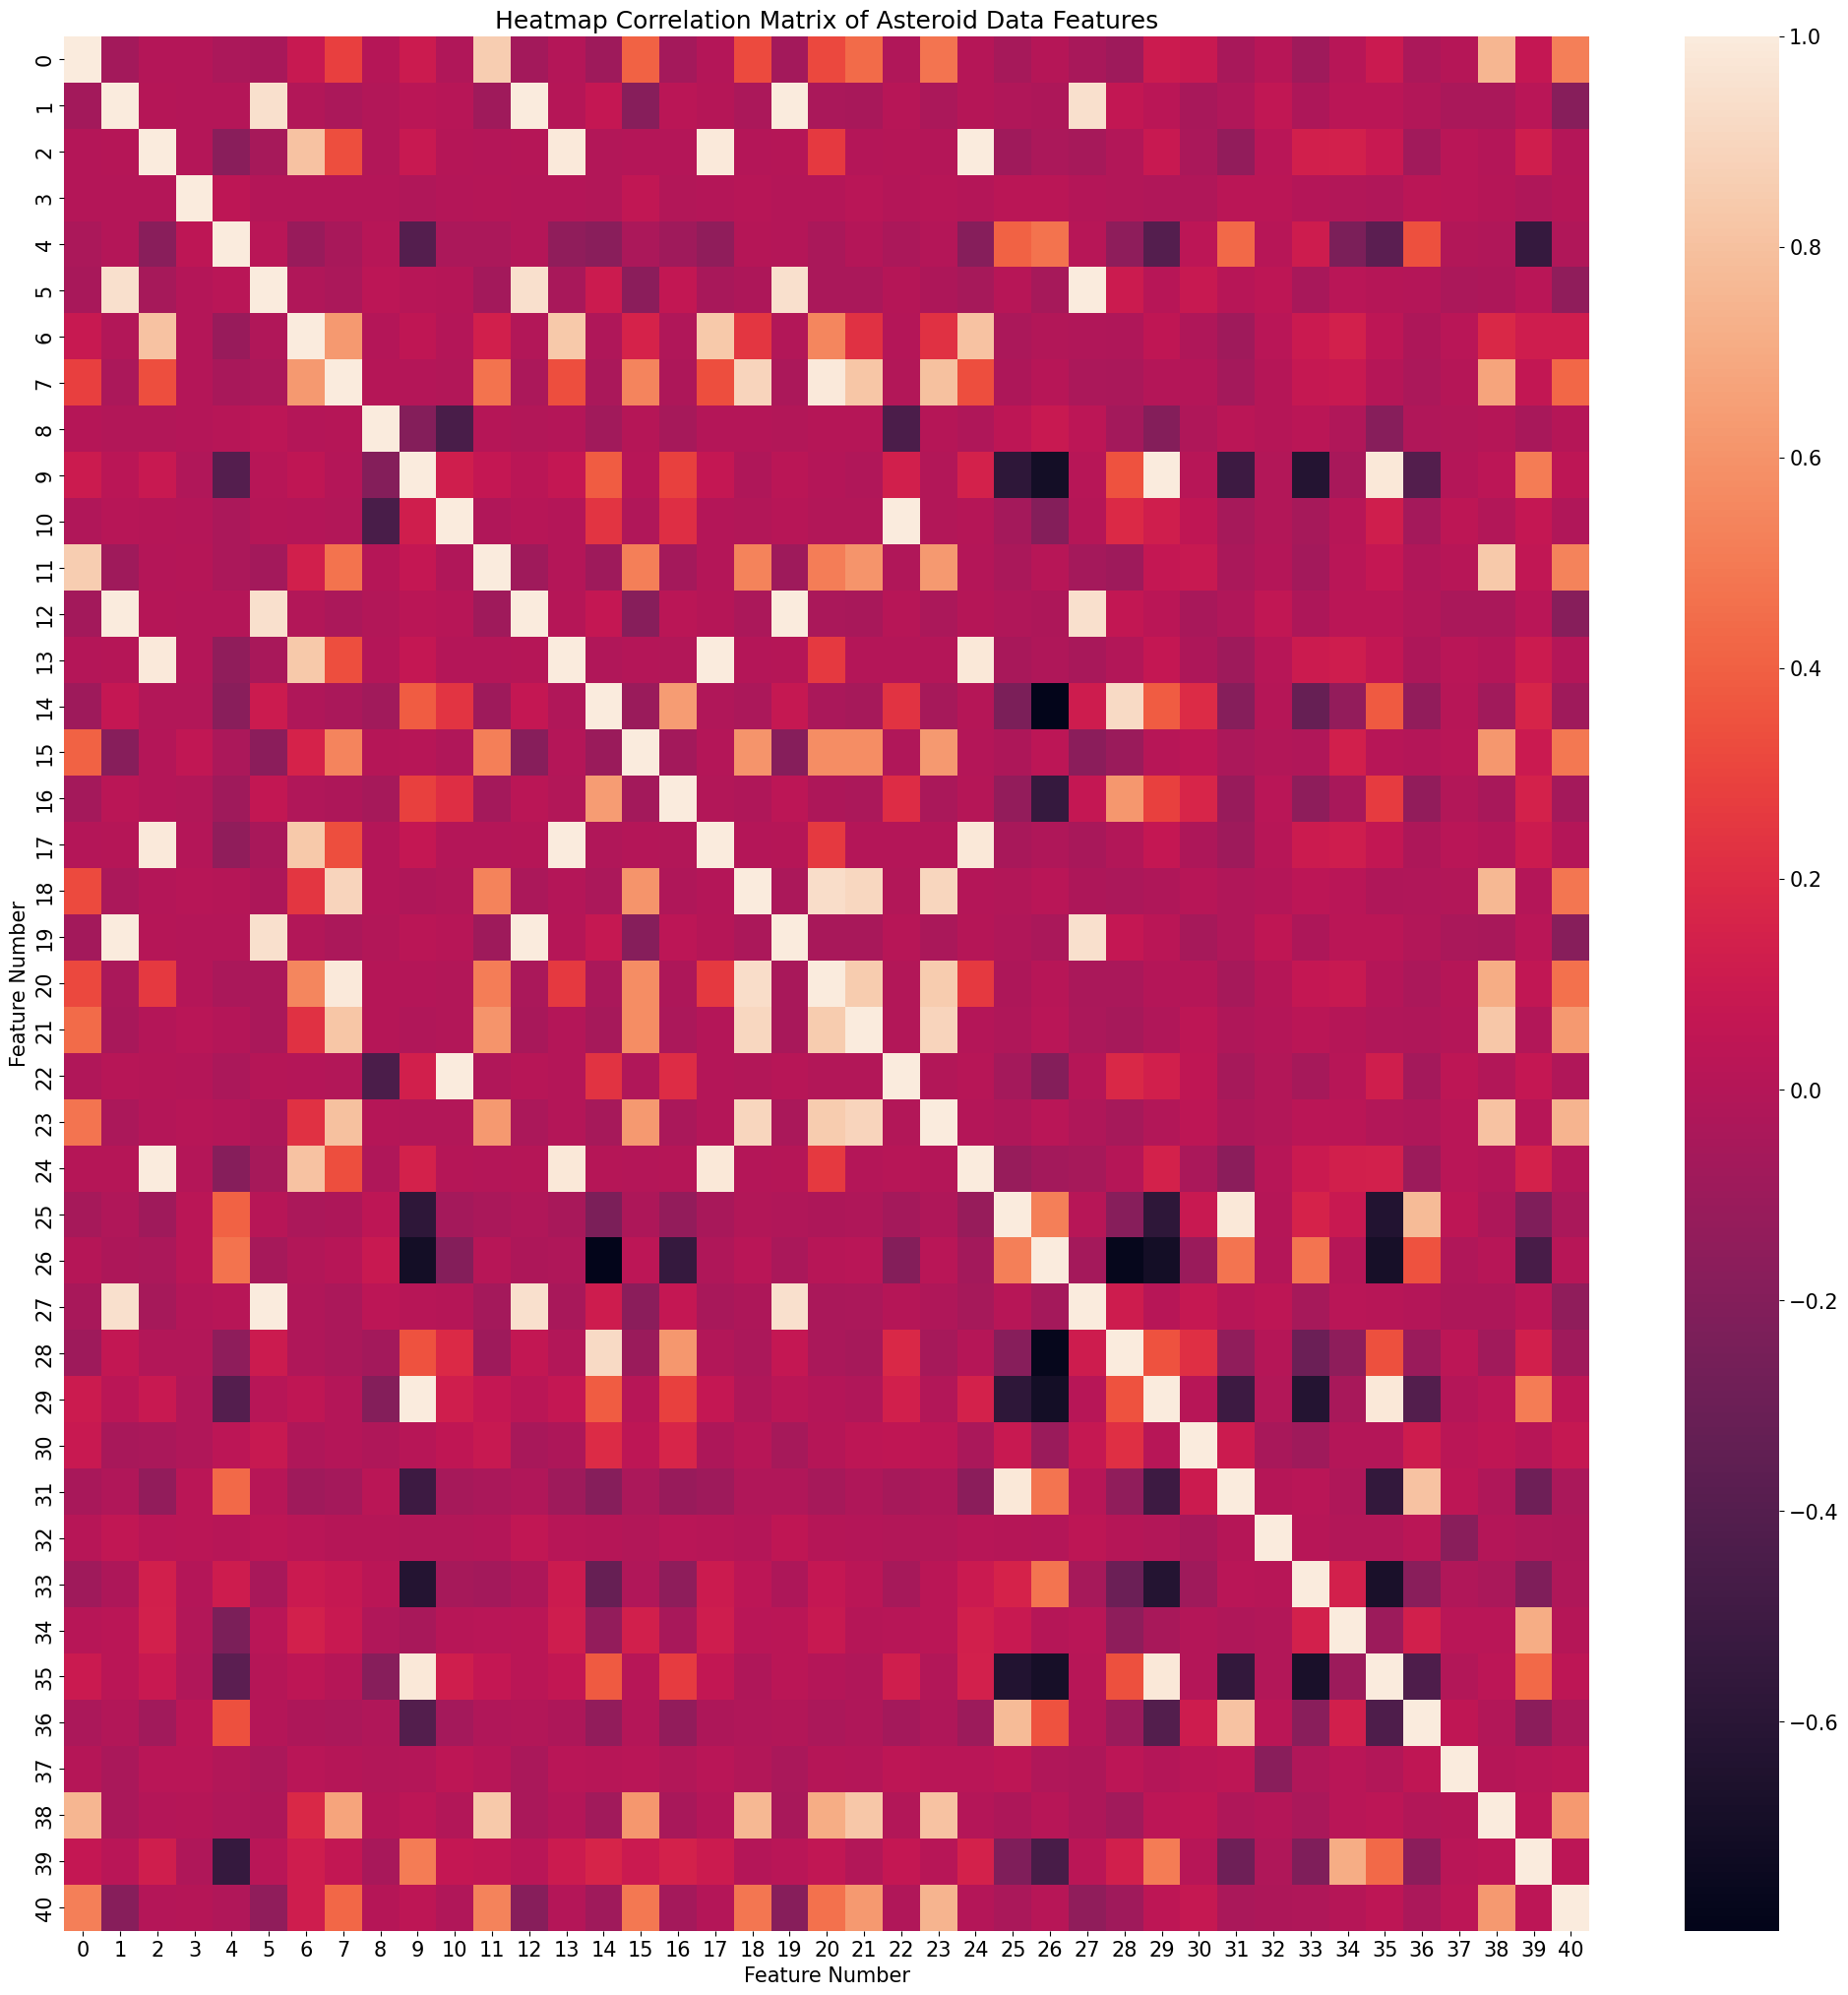

In [11]:
#Check the Correlation between features without PCA
sns.heatmap(scaled_data.corr())
plt.title('Heatmap Correlation Matrix of Asteroid Data Features')
plt.ylabel('Feature Number')
plt.xlabel('Feature Number')
plt.show()

*Figure 2: Correlation Matrix of 42 remaining features in the dataset*

### **Create a Scree plot to determine the proper number of components**

---

#### Research has shown that one way of properly determining the `n_components` hyperparmeter for the PCA algorithm is to visualize the data using a Scree plot, which can be seen in Figure 3. Essentially it shows the eigenvalues for each individual principle component. All features are used then the PCA model is fit to the data. The explained variance of the resulting model (the eigenvalues) are then plotted on the y-axis and the number of features on the x-axis.
#### An interesting geology note, according to Sanchita Managale, contributor to an article on the website Medium,  "In the PCA literature, the plot is called a ‘Scree’ Plot because it often looks like a ‘scree’ slope, where rocks have fallen down and accumulated on the side of a mountain."[2]

#### I also assessed the variance to determine that the selected number of PC's described 80% of the variance. As can be seen in Figure 4, the selection of 10 PC's descibes 80% of the variance

In [12]:
covariance_matrix = PCA(n_components = len(scaled_data.columns))
covariance_matrix.fit(scaled_data)

PCA(n_components=41)

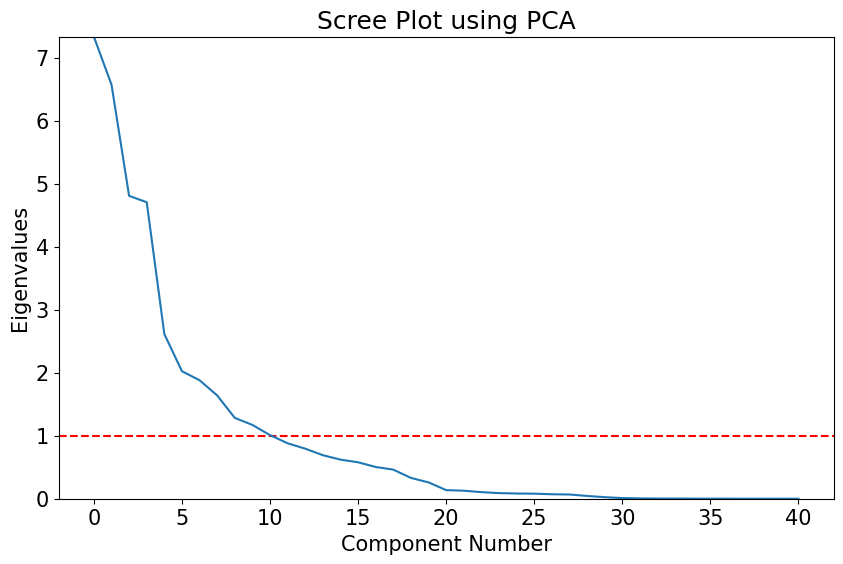

In [13]:
plt.figure(figsize=(10,6))
plt.ylabel('Eigenvalues')
plt.xlabel('Component Number')
plt.title('Scree Plot using PCA')
plt.ylim(0,max(covariance_matrix.explained_variance_))
plt.style.context('seaborn-whitegrid')
plt.axhline(y=1, color='r', linestyle='--')
plt.plot(covariance_matrix.explained_variance_)
plt.show()

<center><i>Figure 3: Scree plot to determine the proper number of components. Using the Kaiser rule, I picked the number of components where the eignevalues equaled 1</i></center>

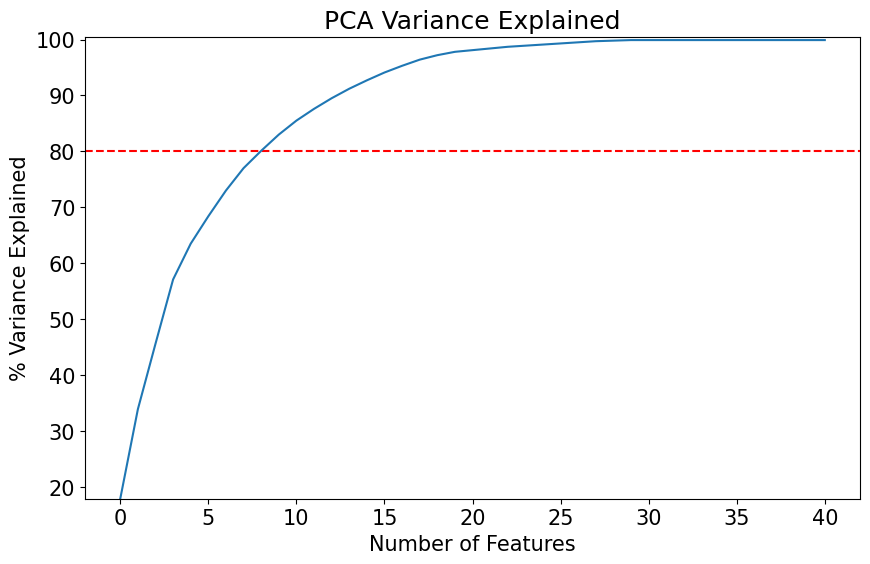

<Figure size 1000x600 with 0 Axes>

In [14]:
variance = covariance_matrix.explained_variance_ratio_
var=np.cumsum(np.round(covariance_matrix.explained_variance_ratio_, decimals=3)*100)

plt.figure(figsize=(10,6))
plt.ylabel('% Variance Explained')
plt.xlabel('Number of Features')
plt.title('PCA Variance Explained')
plt.ylim(min(var), 100.5)
plt.style.context('seaborn-whitegrid')
plt.axhline(y=80, color='r', linestyle='--')
plt.plot(var)
plt.figure(figsize=(10,6))
plt.show()

<center><i>Figure 4: Plot of the variance explained ratio, which shows that 80% of the variance is described by 10 PC's.</i></center>

In [15]:
#Applying PCA
#Setting number of Principal Components to 10
%%time
pca = PCA(n_components = 10)
data_pca = pca.fit_transform(scaled_data)
data_pca = pd.DataFrame(data_pca,columns=['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10',])

CPU times: user 6.14 ms, sys: 8.83 ms, total: 15 ms
Wall time: 4.93 ms


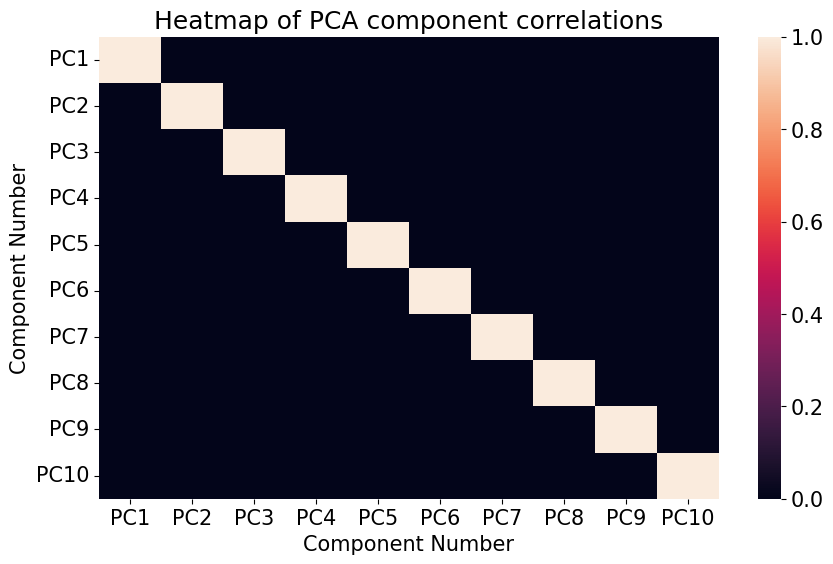

In [16]:
#Checking Correlation between features after PCA
plt.figure(figsize=(10,6))
sns.heatmap(data_pca.corr())
plt.ylabel('Component Number')
plt.xlabel('Component Number')
plt.title('Heatmap of PCA component correlations')
plt.show()

<center><i>Figure 5: Correlation Matrix after applying PCA</i></center>

Utilizing PCA, the data has been mapped from higher dimensional feature space to a lower-dimensional feature space and then visualizing it shows that there is no correlation between the principle components. Therefore, I believe I have achevied my goal of reducing the number of features via dimensionality reduction. Just to ensure that the PCA model I have built represents the higher dimensional data, I will run it through the trust worthiness metric.

In [17]:
print(f"{trustworthiness(scaled_data, data_pca, n_neighbors=5):.2f}")

0.99


A very high score of 0.99 indicates that as described in the documentation, "the local structure is retained."[3]

Finally, I experimented with plotting the PC's. Plotting PC2 and PC3 doesn't really show clear seperation of clusters, unless you zoom in on them. Even then, there is still a lot of overlap

In [18]:
fig = px.scatter(data_frame=data_pca, x='PC2', y='PC3', color=y_asteroid_class)
fig.update_layout(
    title="PCA visualization of Component 2 and Component 3 for the Asterank Asteroid dataset",
    title_x=0.5,
    xaxis_title="Second Principal Component",
    yaxis_title="Third Principal Component",
)
fig.show()

<center><i>Figure 6: Scatter Plot of PC 2 and 3</i></center>

## Dimensionality reduction with UMAP
I decided to use the same standardized data as for PCA. I plotted the data in a scatterplot and ran the trustworthiness algorithm. For the final notebook, I would like to investigate the tuning of hyperparameters for this algorithm more.

In [19]:
%%time

# Fit UMAP to processed data
data_umap = umap.UMAP(n_neighbors=5).fit_transform(scaled_data)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



CPU times: user 29.3 s, sys: 1.99 s, total: 31.2 s
Wall time: 22.8 s


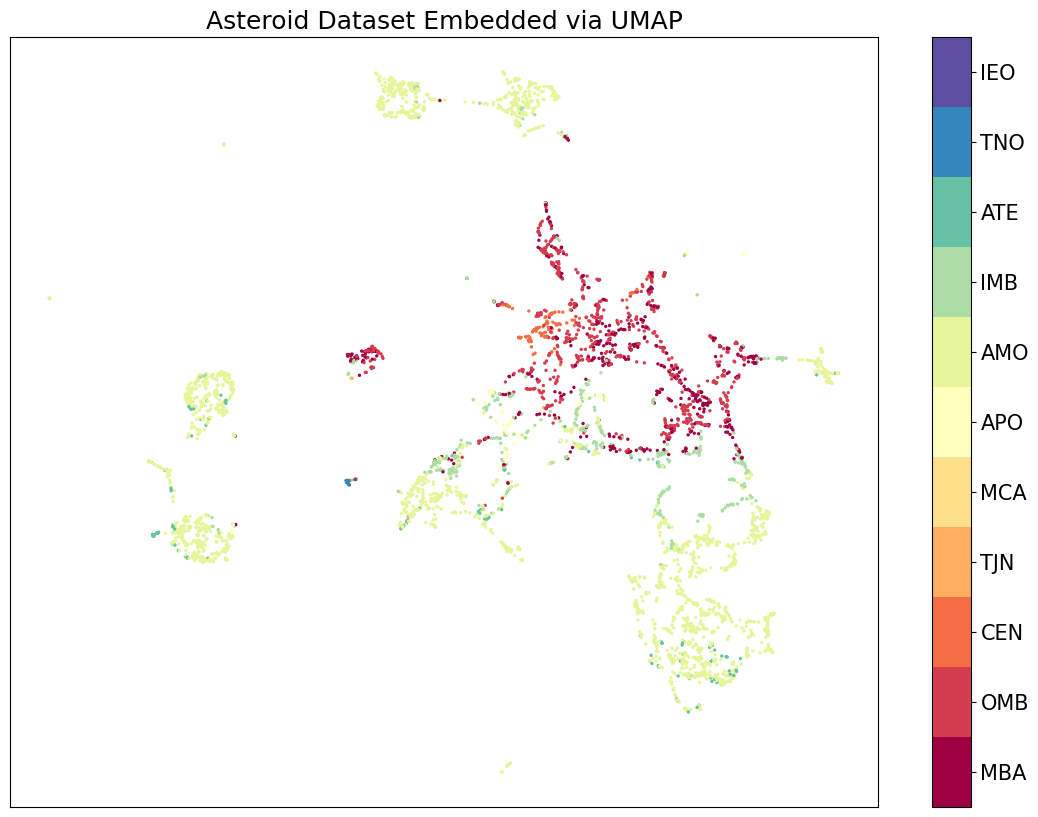

In [20]:
fig, ax = plt.subplots(1, figsize=(14, 10))
plt.scatter(*data_umap.T, s=2, c=y_asteroid_class, cmap='Spectral', alpha=1.0)
plt.setp(ax, xticks=[], yticks=[])
cbar = plt.colorbar(boundaries=np.arange(12)-0.5)
cbar.set_ticks(np.arange(11))
cbar.set_ticklabels(classes)
plt.title('Asteroid Dataset Embedded via UMAP');


<center><i>Figure 7: Scatter Plot of the 11 asteroid classifications embedded in a lower dimensionality feature space/i></center>

In [21]:
print(f"{trustworthiness(scaled_data, data_umap, n_neighbors=5):.2f}")

0.99


## Dimensionality Reduction using t-SNE

In [22]:
# This takes a really long time to run (approx 3 mins), even using the GPU, because the algorithm is computationally expensive.
# I also have the perplexity set very high, as this high value was giving better results.
# I'm considereing taking the PCA results and then
# reducing the dimensionality even more by feeding those into the t-SNE algorithm
%%time
tsne = TSNE(n_components=2, perplexity=400, random_state=42)
X_tsne = tsne.fit_transform(scaled_data)


CPU times: user 2min 57s, sys: 12.8 s, total: 3min 10s
Wall time: 51.5 s


After fitting and transforming the scaled data, I show the Kullback-Leibler (KL) divergence between the high and low-dimensional probability distributions. The lower the KL divergence usually is indiactive of "better" results [4]. This value is a little high, indicating that using the transformed t-SNE data would result in a high loss of information. Ideally this value would be closer to 0. However, the trustworhiness score is really high as well. In the final notebook I may look at Shepard diagrams as well as more ranking-based metrics. I am also considering using the results of the PCA model that have been reduced and feeding those into the t-SNE algorithm.

In [23]:
tsne.kl_divergence_

0.6390583515167236

In [24]:
fig = px.scatter(x=X_tsne[:, 0], y=X_tsne[:, 1], color=y_asteroid_class)
fig.update_layout(
    title="t-SNE visualization of Asteroid dataset",
    title_x=0.5,
    xaxis_title="First t-SNE",
    yaxis_title="Second t-SNE",
)
fig.show()

<center><i>Figure 7: Scatter Plot of the 11 asteroid classifications embedded in a lower dimensionality feature space looking at the first and second t-SNE components/i></center>

In [25]:
%%time
# I know where are not supposed to include commented out code, but this was one of the algorithms I was using for tuning the perplexity hyperparmeter.
# I will most likey remove this for the final notebook.
'''
perplexity = np.arange(120, 220, 10)
divergence = []

for i in perplexity:
    model = TSNE(n_components=2, init="pca", perplexity=i)
    reduced = model.fit_transform(scaled_data)
    divergence.append(model.kl_divergence_)
fig = px.line(x=perplexity, y=divergence, markers=True)
fig.update_layout(xaxis_title="Perplexity Values", yaxis_title="Divergence")
fig.update_traces(line_color="red", line_width=1)
fig.show()
'''

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.3 µs


'\nperplexity = np.arange(120, 220, 10)\ndivergence = []\n\nfor i in perplexity:\n    model = TSNE(n_components=2, init="pca", perplexity=i)\n    reduced = model.fit_transform(scaled_data)\n    divergence.append(model.kl_divergence_)\nfig = px.line(x=perplexity, y=divergence, markers=True)\nfig.update_layout(xaxis_title="Perplexity Values", yaxis_title="Divergence")\nfig.update_traces(line_color="red", line_width=1)\nfig.show()\n'

In [26]:
print(f"{trustworthiness(scaled_data, X_tsne, n_neighbors=5):.2f}")

0.98


# Assignment Questions

---


#### **Which method did you like the most?**
Personally, I think I like PCA the most. Using the Scree plot and explained variance to help choose the `n_components` hyperparmeter was super straightforward and completely made sense to me. I watch a bunch of videos about the 3 different techniques, and PCA seems to make the most sense to me.
#### **Which method did you like the least?**
I dislike the t-SNE algorithm the least because of the time it took process. The loop I created to try different `perplexity` hyperparmeter values took an extremely long time.
#### **How did you score these unsupervised models?**
With PCA I used a correlation matrix before and after applying dimensionality reduction. The plots clearly show that there was a high correlation before between the high dimensional feature space and no correlation in the lower dimension feature space. I also used the trustworthiness metric, which returned an incredibly high score of 0.98.

For UMAP and t-SNE, I plotted the results on a scatter plot and then color coded them using the asteroid class encoding I derived during preprocessing. I also used the trustworthiness metric for both of these algorithms. For UMAP I saw a score of 0.99 and for t-SNE 0.98.

I also applied the Kullback-Leibler (KL) divergence to the t-SNE results. This algorithm is used to compare 2 data distributions. The value of 0.639 indicates that the probabilty distrobutions are pretty different, which is not the result we want when mapping to a lower dimension feature space. I will spend more time with Shepard diagrams as well as more ranking-based metrics for the final notebook.
#### **Did the output align with your geologic understanding?**
From the scatter plots, at least the ones for UMAP and t-SNE, I would expect to see clusters formed for each of the asteroid location classes, as some of the features such as the orbital elements will determine that. However, I don't really see clear clusters formed via t-SNE or UMAP.
#### **What did you want to learn more about?**
From research, it appears that usually PCA is applied first to a dataset for reduction, and then followed up by t-SNE. In the next week as I prepare for the final submittal, I plan on diving more into how these unsupervised learning algorithms can be used together and if there are any other techniqies for tuning hyperparmeters for the UMAP and t-SNE algorithms.
#### **Did you pre-process your data?**
I did pre-process my data. I stripped out all string values, except the 2 columns I used as labels, which I encoded. I applied slightly different standardization techniques based off which algorithm I decided to use.
#### **What was a decision you were most unsure about?**
The choice of hyperparmeters for UMAP and t-SNE. I tried some different values based off some of the research I did into these algorithms, but it was difficult for me to tell if the choices I was making impacting the perfomance of the algorithms.

# References


---


#### [1] https://www.asterank.com/about
#### [2] https://sanchitamangale12.medium.com/scree-plot-733ed72c8608
#### [3] https://scikit-learn.org/1.5/modules/generated/sklearn.manifold.trustworthiness.html
#### [4] https://medium.com/@hosamedwee/kullback-leibler-kl-divergence-with-examples-part-2-9123bff5dc10#:~:text=The%20KL%20divergence%20can%20then,likely%20doing%20a%20good%20job.
